# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

import scipy.constants
from scipy.sparse import csgraph

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

from tqdm import tqdm, trange

import itertools
import math

from numba import jit, njit
from numba import njit
from numba_progress import ProgressBar

from tabulate import tabulate

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [2]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=4

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
F_D_MAX = 2*N_MAX + I1_D + I2_D
print(f"{N_STATES} states loaded from molecule.")

GAUSS = 1e-4 # T

Rb87Cs133NMax4
800 states loaded from molecule.


# Load precomputed results

In [3]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

LABELS_D=data['labels_d']
LABELS_DEGENERACY = data['labels_degeneracy']
STATE_JUMP_LIST = data['state_jump_list']

TRANSITION_LABELS_D = data['transition_labels_d']
TRANSITION_INDICES = data['transition_indices']
EDGE_JUMP_LIST = data['edge_jump_list']


MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_SPARSE=data['couplings_sparse']
TRANSITION_GATE_TIMES_POL = data['transition_gate_times_pol']
TRANSITION_GATE_TIMES_UNPOL = data['transition_gate_times_unpol']

CUMULATIVE_TIME_FROM_INITIALS_POL = data['cumulative_pol_time_from_initials']
PREDECESSOR_POL = data['predecessor_pol_time_from_initials']

CUMULATIVE_TIME_FROM_INITIALS_UNPOL = data['cumulative_unpol_time_from_initials']
PREDECESSOR_UNPOL = data['predecessor_unpol_time_from_initials']

PAIR_RESONANCE = data['pair_resonance']

def label_degeneracy(N,MF_D):
    return LABELS_DEGENERACY[N,(MF_D+F_D_MAX)//2]

@jit(nopython=True)
def label_d_to_node_index(N,MF_D,d):
    return STATE_JUMP_LIST[N,(MF_D+F_D_MAX)//2]+d

@jit(nopython=True)
def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return EDGE_JUMP_LIST[label_d_to_node_index(N,MF_D,d)]

INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = np.array([label_d_to_node_index(*label_d) for label_d in INITIAL_STATE_LABELS_D])
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)
print("Loaded precomputed data.")

Loading precomputed data...
Loaded precomputed data.


# Helper Functions

In [4]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)
    
def fid_to_string(fid):
    return f"{fid:.4f}({fidelity(fid,d=9):.1f})"

In [5]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [6]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

def round_to_n(x, n): 
    return round(x, -int(np.floor(np.log10(max(x,1e-20)))) + (n - 1))

In [7]:
@jit(nopython=True)
def label_pair_to_edge_index(label1,label2):
    first_indices = label_d_to_edge_indices(label1[0],label1[1],label1[2])
    section = 3*((label2[0] - label1[0]) < 0) + [0,1,2][(label2[0] - label1[0])*(label1[1] - label2[1])//2]
    return first_indices[section]+label2[2]

# TRANSITION_LABELS_D[label_pair_to_edge_index((1,4,3),(0,2,1))]
TRANSITION_LABELS_D[label_pair_to_edge_index(np.array([1,4,3]),np.array([0,2,1]))]

array([1, 4, 3, 0, 2, 1])

# Zeeman Plot

plotting zeeman diagram...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex val

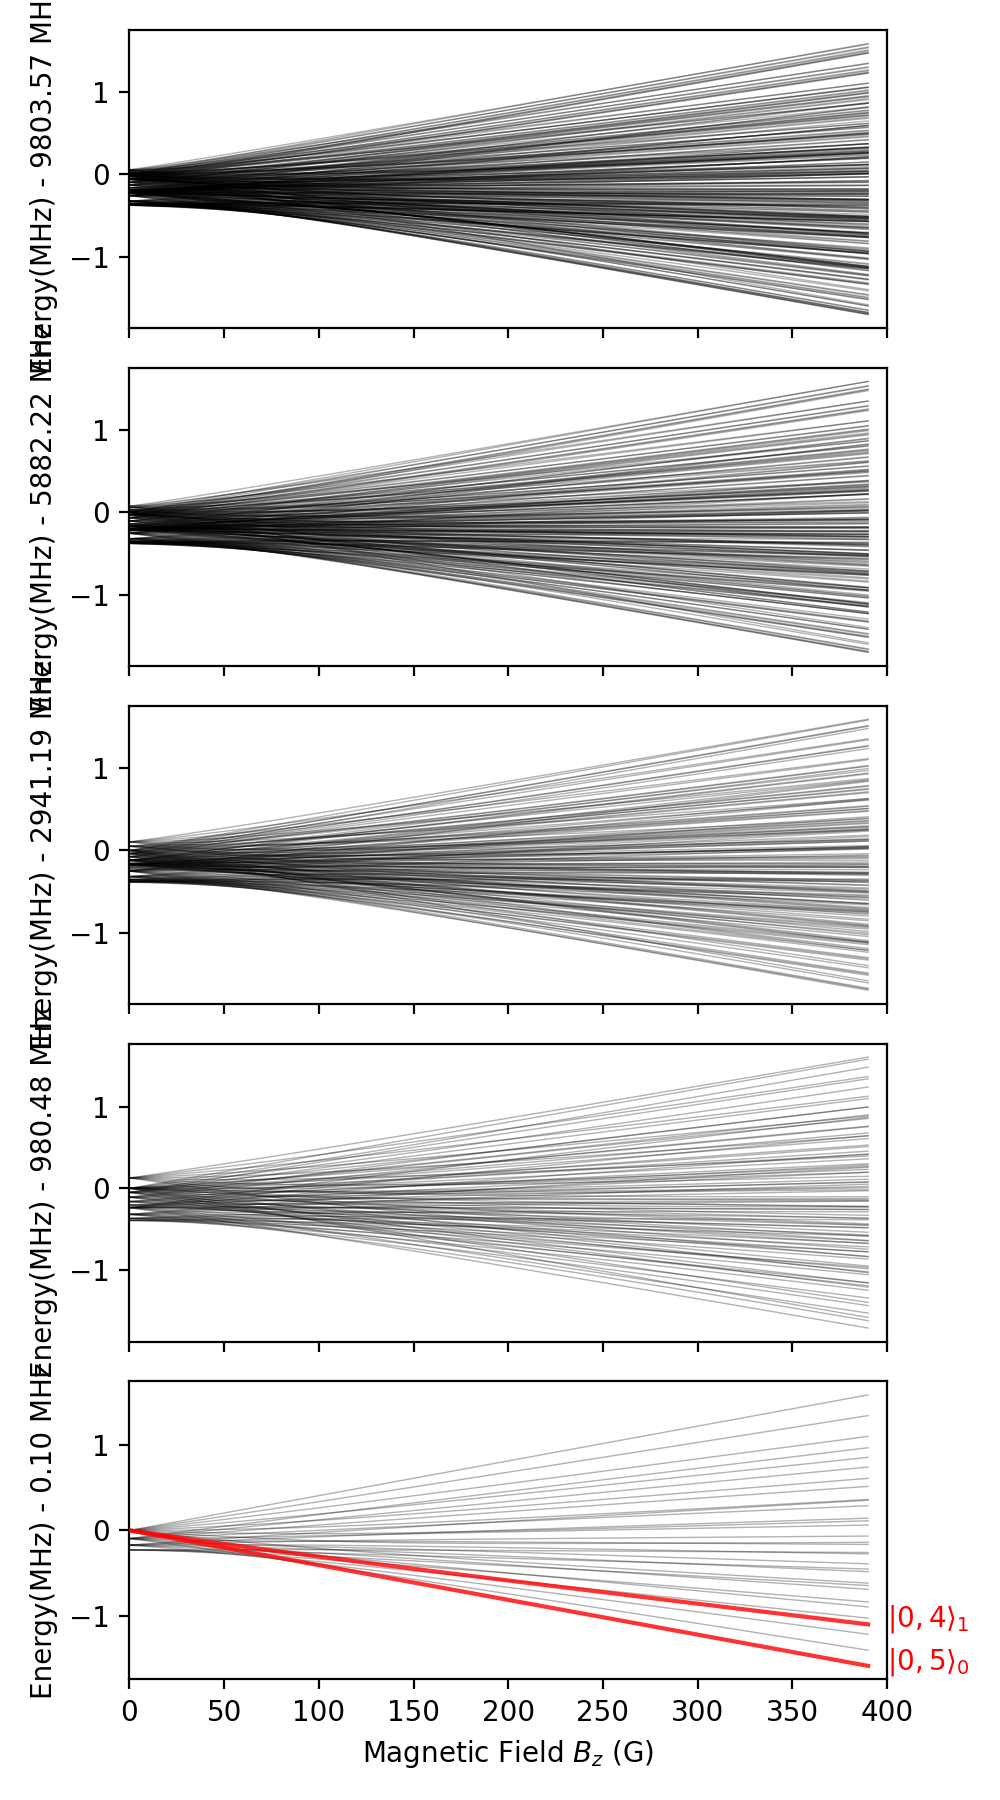

In [8]:
print("plotting zeeman diagram...")
fig, axs = plt.subplots(5,1,figsize=(5,9),sharex = True)

b_max_plot_gauss = 400
b_max_plot_bi = field_to_bi(b_max_plot_gauss)

axs[0].set_xlim(0,b_max_plot_gauss)
axs[-1].set_xlabel('Magnetic Field $B_z$ (G)')

N=N_MAX
for ax in axs:
    base_energy = np.abs(ENERGIES[PER_MN*(N)**2,0]/(scipy.constants.h*1e6))
    ax.set_ylabel(f'Energy(MHz) - {base_energy:.2f} MHz')
    for si in range(PER_MN*(N)**2,PER_MN*(N+1)**2):
        if si in INITIAL_STATE_INDICES:
            ax.plot(B[:b_max_plot_bi]/GAUSS,ENERGIES[si,:b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,c='red',lw=1.5, alpha=0.8,zorder=10)
            ax.text(B[b_max_plot_bi]/GAUSS,ENERGIES[si,b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,f"${label_d_to_latex_string(LABELS_D[si])}$",c='red')
        else:
            ax.plot(B[:b_max_plot_bi]/GAUSS,ENERGIES[si,:b_max_plot_bi]/(scipy.constants.h*1e6)-base_energy,c='black',lw=0.5, alpha=0.3,zorder=1)
    N-=1

fig.savefig(f'../appendix/images/{MOLECULE_STRING}-zeeman.pdf')

# Magnetic moments plot

plotting magnetic moments...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


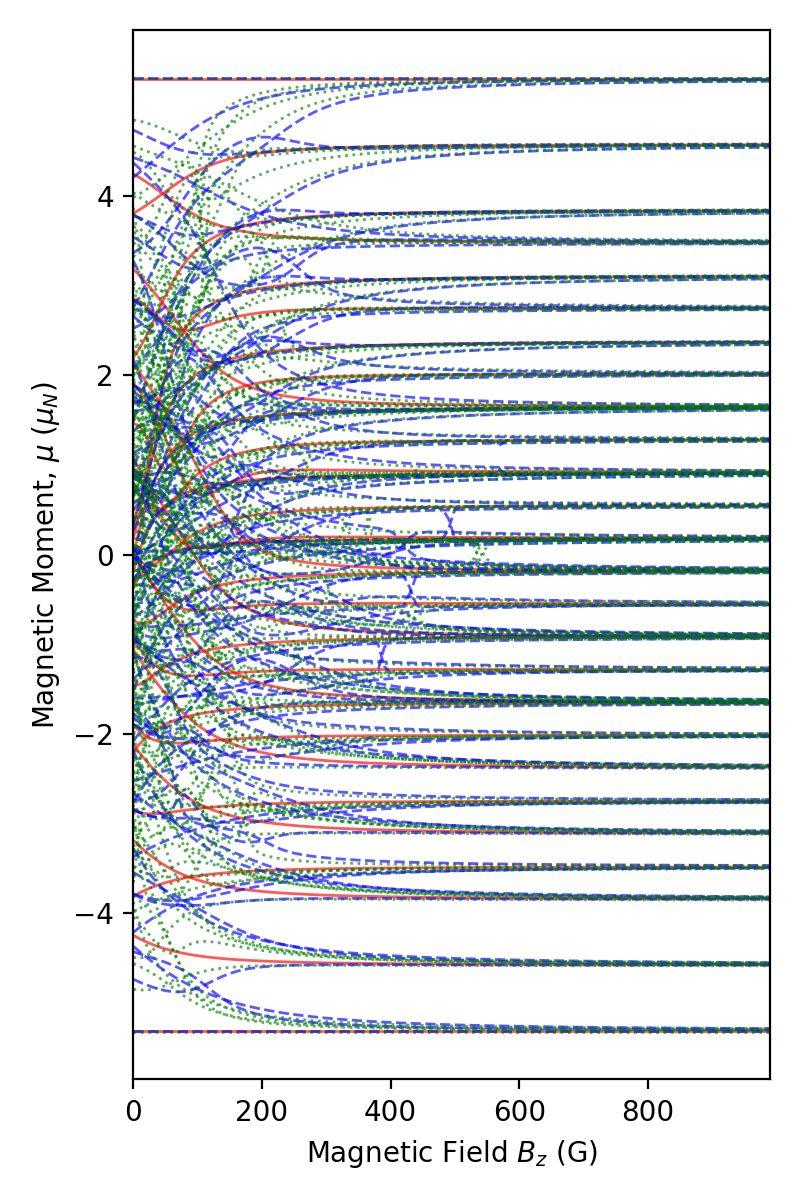

In [9]:
print("plotting magnetic moments...")
fig, ax = plt.subplots(figsize=(4,6))

ax.set_xlim(0,B_MAX/GAUSS)
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Magnetic Moment, $\mu$ $(\mu_N)$')

states_to_plot = []
for N in range(0,3):
    Fd = 2*N + I1_D + I2_D
    for MF_D in range(-Fd,Fd+1,2):
        for di in range(label_degeneracy(N,MF_D)):
            states_to_plot.append((N,MF_D,di))

for state_label in states_to_plot:
    lw=1
    col = 'red'
    ls = 'solid'
    if state_label[0] == 1:
        ls = 'dashed'
        col='blue'
        lw=1
    if state_label[0] == 2:
        ls = 'dotted'
        col='green'
        lw=1
    
    index = label_d_to_node_index(*state_label)
    ax.plot(B/GAUSS, MAGNETIC_MOMENTS[index,:]/muN,linestyle=ls, color=col, alpha=0.65,linewidth=lw);

fig.savefig(f'../appendix/images/{MOLECULE_STRING}-magnetic-dipole-moments.pdf')

# Find best state Pi-pulse paths

In [10]:
latex_string = r"""\begin{tikzpicture}[node distance=2em, every node/.style={rounded corners, draw, minimum size=2em,fill=white},
        mid-arrow/.style={decoration={markings, mark=at position 0.6 with {\arrow[#1]{stealth}}}, postaction={decorate}},
        yscale=0.9
        ]"""

CUTOFF_TIME = 1.5e-5
CUTOFF_BI = field_to_bi(181.5)
from pyvis.network import Network
# net = Network(height="1000px",width="75%",directed=False,notebook=True,cdn_resources='in_line',neighborhood_highlight=False,layout=None,filter_menu=False)
# net.repulsion()

edges = set()

cm = matplotlib.cm.get_cmap('Spectral')
colours = cm(np.linspace(0,1,N_INITIAL_STATES))
colours_hex = [matplotlib.colors.to_hex(c, keep_alpha=False) for c in colours]

latex_string += r"""\draw [thick] (-1.6, 10) -- (-1.4,10) node[left, draw=none,fill=none] {0};
        \draw [ultra thick, ->] (-1.5,10) -- (-1.5,0.5) node[midway,above, draw=none, rotate=90,fill=none] {Time};
        \foreach \y in {0,...,9} 
            \draw[dotted, gray] (-1.5,10-\y) -- (13.3,10-\y);"""


for si in range(N_STATES):
    time = CUMULATIVE_TIME_FROM_INITIALS_UNPOL[si,CUTOFF_BI]
    if time < CUTOFF_TIME: # Use me
        # Build tree
        start_label = LABELS_D[si]
        start_si = si
        
        current_back = si
        current_back_label = LABELS_D[si]
        predecessor_list = PREDECESSOR_UNPOL[:,CUTOFF_BI]
        while current_back not in INITIAL_STATE_INDICES:
            next_back = predecessor_list[current_back]
            next_back_label = LABELS_D[next_back]
            edges.add((current_back,next_back))
            current_back = next_back
            current_back_label = next_back_label
        
        this_y=((CUTOFF_TIME-time)/(CUTOFF_TIME))
        this_x=float(
            (
                start_label[1]-current_back_label[1]
                + 2*start_label[2]/label_degeneracy(start_label[0],start_label[1])
            )*0.05)*(1-this_y)**(0.1) + current_back*0.7
    
        state_label = LABELS_D[si]
        label_string = label_d_to_string(state_label)
        # net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*2000, value=float(time),color=colours_hex[0],title=f"{label_string}, cumulative time={time}",physics=False)
        # net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*4000,color=colours_hex[0],title=f"{label_string}, cumulative time={time}",physics=False)
        latex_string += "\n    "
        latex_string += fr"\node[draw] at ({(this_x-20.8)*10:.1f}, {this_y*10:.3f}) ({si}) {{\footnotesize${label_d_to_latex_string(LABELS_D[si])}$}};"
        
    
pcol = ['blue','red','green']
for s,t in edges:
    fid = 1#float(TRANSITION_GATE_TIMES_UNPOL[t,CUTOFF_BI])
    from_i = int(t)
    to_i = int(s)
    P = round((LABELS_D[from_i][1] - LABELS_D[to_i][1])*(LABELS_D[from_i][0] - LABELS_D[to_i][0])/2)
    ecol = pcol[P]
    # net.add_edge(int(t),int(s), value=fidelity(fid,d=5),arrowStrikethrough=False,color=ecol,title=f"{fid}",physics=True)
    latex_string += "\n    "
    latex_string += fr"\draw [thick, {ecol},mid-arrow] ({int(t)}) -- ({int(s)});"
    
latex_string += "\n"
latex_string += "\end{tikzpicture}"
            

# net.prep_notebook()
# net.show_buttons(filter_=['physics'])
print(latex_string)

\begin{tikzpicture}[node distance=2em, every node/.style={rounded corners, draw, minimum size=2em,fill=white},
        mid-arrow/.style={decoration={markings, mark=at position 0.6 with {\arrow[#1]{stealth}}}, postaction={decorate}},
        yscale=0.9
        ]\draw [thick] (-1.6, 10) -- (-1.4,10) node[left, draw=none,fill=none] {0};
        \draw [ultra thick, ->] (-1.5,10) -- (-1.5,0.5) node[midway,above, draw=none, rotate=90,fill=none] {Time};
        \foreach \y in {0,...,9} 
            \draw[dotted, gray] (-1.5,10-\y) -- (13.3,10-\y);
    \node[draw] at (0.8, 2.725) (25) {\footnotesize$|0,2\rangle_{3}$};
    \node[draw] at (7.7, 1.206) (28) {\footnotesize$|0,3\rangle_{2}$};
    \node[draw] at (2.0, 10.000) (30) {\footnotesize$|0,4\rangle_{1}$};
    \node[draw] at (9.0, 10.000) (31) {\footnotesize$|0,5\rangle_{0}$};
    \node[draw] at (1.3, 7.107) (111) {\footnotesize$|1,3\rangle_{2}$};
    \node[draw] at (1.9, 3.768) (117) {\footnotesize$|1,3\rangle_{8}$};
    \node[draw] at (8.2

# Generic Optimisation Routine

In [11]:
# @njit(nogil=True)
def maximise_fid_dev(possibilities, progress_proxy, max_bi=B_STEPS, loop=False, required_crossing=None,
                     travel_frac=0.2, pol_eff=0.7, dev_exp=(1/3), coincidental_outflow=True
                    ):
    n_comb = len(possibilities)
    n_states = len(possibilities[0])
    n_waves = n_states - 1 + loop # NOTE: assumes paths are the same length
    consider_top = 50
    print(n_comb, "combinations to consider")
    
    possibilities_indices = np.zeros((n_comb,n_states),dtype=np.uint)
    for combi, possibility in enumerate(possibilities):
        for posi, label in enumerate(possibility):
            node_index = label_d_to_node_index(label[0],label[1],label[2])
            possibilities_indices[combi,posi]=node_index

    unpol_db_req = np.zeros((consider_top, B_STEPS),dtype=np.double)
    pol_db_req = np.zeros((consider_top, B_STEPS),dtype=np.double)
    
    unpol_distance_time = np.zeros((consider_top, B_STEPS),dtype=np.double)
    unpol_distance_start = np.zeros((consider_top,B_STEPS),dtype=np.uint)
    pol_distance_time = np.zeros((consider_top, B_STEPS),dtype=np.double)   
    pol_distance_start = np.zeros((consider_top,B_STEPS),dtype=np.uint)
    
    unpol_time = np.zeros((consider_top, B_STEPS),dtype=np.double)
    pol_time = np.zeros((consider_top, B_STEPS),dtype=np.double)
    
    rating = np.zeros((consider_top, B_STEPS),dtype=np.double)
    peak_rating =  np.zeros((consider_top),dtype=np.double)
    peak_rating_index = np.zeros((consider_top),dtype=np.uint)

    worst_rating_so_far = 0
    for i, desired_indices in enumerate(possibilities_indices):
        
        # Find path to get there from initial state
        this_unpol_distance_time_i = np.argmin(CUMULATIVE_TIME_FROM_INITIALS_UNPOL[desired_indices,:],axis=0)
        dims_unpol = np.expand_dims(this_unpol_distance_time_i,axis=0)
        this_unpol_distance_time = np.take_along_axis(CUMULATIVE_TIME_FROM_INITIALS_UNPOL[desired_indices,:],dims_unpol,axis=0)[0]
        this_unpol_distance_pre = np.take_along_axis(PREDECESSOR_UNPOL[desired_indices,:],dims_unpol,axis=0)[0]

        this_pol_distance_time_i = np.argmin(CUMULATIVE_TIME_FROM_INITIALS_POL[desired_indices,:],axis=0)
        dims_pol = np.expand_dims(this_pol_distance_time_i,axis=0)
        this_pol_distance_time = np.take_along_axis(CUMULATIVE_TIME_FROM_INITIALS_POL[desired_indices,:],dims_pol,axis=0)[0]
        this_pol_distance_pre = np.take_along_axis(PREDECESSOR_POL[desired_indices,:],dims_pol,axis=0)[0]
        
        # Find t_gate to get 9's fidelity
        this_unpol_t_gate = np.zeros(B_STEPS,dtype=np.double)
        this_pol_t_gate = np.zeros(B_STEPS,dtype=np.double)
        for wn in range(n_waves):
            i1 = desired_indices[(wn)%n_states]
            i2 = desired_indices[(wn+1)%n_states]
            l1 = LABELS_D[i1]
            l2 = LABELS_D[i2]
            P = (l2[0]-l1[0])*(l2[1]-l1[1]) # -2 , 0 , 2
            if P == 0:
                section_index = 0                
            elif P == -2:
                section_index = 1
            elif P == 2:
                section_index = 2
            
            edge_index = label_pair_to_edge_index(l1,l2)
            this_w = PAIR_RESONANCE[edge_index,:]
            
            this_pol_t_gate = np.maximum(this_pol_t_gate, TRANSITION_GATE_TIMES_POL[edge_index,:])
            this_unpol_t_gate = np.maximum(this_unpol_t_gate, TRANSITION_GATE_TIMES_UNPOL[edge_index,:])
            
            if coincidental_outflow:
                for pi in desired_indices: 
                    if pi == i1 or pi == i2:
                        continue
                    # For all other states, check we don't drive population out with the frequency
                    lo = LABELS_D[pi]

                    upwards = ((l2[0]-l1[0]==1) and (lo[0]==l1[0])) or ((l2[0]-l1[0]==-1) and (lo[0]==l2[0]))
                    skip=0
                    if not upwards:
                        skip=3

                    other_state_edge_labels_d = EDGE_JUMP_LIST[pi] # Other state (in topology) viable edges
        
                    other_states_coupling_ratio_unpol = COUPLINGS_SPARSE[other_state_edge_labels_d[skip]:other_state_edge_labels_d[skip+3],:]/COUPLINGS_SPARSE[edge_index,:]
                    other_states_trans_freq_unpol = PAIR_RESONANCE[other_state_edge_labels_d[skip]:other_state_edge_labels_d[skip+3],:]
                    t_gate_restriction_unpol = np.pi * np.sqrt(np.sum((other_states_coupling_ratio_unpol)**2/(np.abs(this_w - other_states_trans_freq_unpol)**2),axis=0))
                    this_unpol_t_gate = np.maximum(this_unpol_t_gate, t_gate_restriction_unpol)

                    other_states_coupling_ratio_pol = COUPLINGS_SPARSE[other_state_edge_labels_d[skip+section_index]:other_state_edge_labels_d[skip+section_index+1],:]/COUPLINGS_SPARSE[edge_index,:]
                    other_states_trans_freq_pol = PAIR_RESONANCE[other_state_edge_labels_d[skip+section_index]:other_state_edge_labels_d[skip+section_index+1],:]
                    t_gate_restriction_pol = np.pi * np.sqrt(np.sum((other_states_coupling_ratio_pol)**2/(np.abs(this_w - other_states_trans_freq_pol)**2),axis=0))
                    this_pol_t_gate = np.maximum(this_pol_t_gate, t_gate_restriction_pol)
                
        # Find Delta B to get 9's fidelity
        all_moments = MAGNETIC_MOMENTS[desired_indices,:].real
        this_deviation = np.empty((B_STEPS),dtype=np.double)
        for bi in range(B_STEPS):
            max_here = all_moments[0,bi]
            min_here = all_moments[0,bi]
            for lsi in range(1,n_states):
                this_moment = all_moments[lsi,bi]
                if this_moment > max_here:
                    max_here=this_moment    
                if this_moment < min_here:
                    min_here=this_moment
            this_deviation[bi] = max_here-min_here

        this_delta_b_req_unpol = scipy.constants.h/(this_deviation*this_unpol_t_gate)
        this_delta_b_req_pol = scipy.constants.h/(this_deviation*this_pol_t_gate)
        
        # Rank this state combination
        rated_b_max = (np.minimum(np.ones(B_STEPS),scipy.constants.h/(this_deviation*(pol_eff*this_pol_t_gate + (1-pol_eff)*this_unpol_t_gate))))**(dev_exp)
        
        rated_time = (  (travel_frac)           * (pol_eff*this_pol_distance_time + (1-pol_eff)*this_unpol_distance_time)
                      +(1-travel_frac)*n_states * (pol_eff*this_pol_t_gate        + (1-pol_eff)*this_unpol_t_gate)
                     )

        this_rating = rated_b_max/rated_time
        
        if required_crossing is not None:
            required_deviation = all_moments[required_crossing[0],:]-all_moments[required_crossing[1],:]
            sign_changes = np.where(np.diff(required_deviation<0))[0]
            mask = np.ones(max_bi, dtype=np.bool_)
            mask[sign_changes] = False
            mask[sign_changes+1] = False
            this_rating[mask] = 0
                
        # Check if this combination makes the top segment 
        this_peak_rating = np.max(this_rating)
        better_array = peak_rating - this_peak_rating # negative values are worse combinations
        the_worst_index = better_array.argmin() # will replace this one if negative
        the_worst_difference = better_array[the_worst_index]
        better_array[the_worst_index] = 1e20
        the_second_worst_index = better_array.argmin() # need second worst to see if this is new worst
        better_array[the_worst_index] = the_worst_difference
        if the_worst_difference < 0: # This set goes into the list where the worst was
            peak_rating[the_worst_index] = this_peak_rating
            peak_rating_index[the_worst_index] = i

            unpol_db_req[the_worst_index] = this_delta_b_req_unpol
            pol_db_req[the_worst_index] = this_delta_b_req_pol
            
            unpol_distance_time[the_worst_index] = this_unpol_distance_time
            pol_distance_time[the_worst_index] = this_pol_distance_time
            
            unpol_distance_start[the_worst_index] = this_unpol_distance_time_i
            pol_distance_start[the_worst_index] = this_pol_distance_time_i

            unpol_time[the_worst_index] = this_unpol_t_gate
            pol_time[the_worst_index] = this_pol_t_gate
        
            rating[the_worst_index] = this_rating
            worst_rating_so_far = min(this_peak_rating,peak_rating[the_second_worst_index])
        else:
            worst_rating_so_far = peak_rating[the_worst_index]

        progress_proxy.update(1)
        
    
    return (unpol_db_req, 
            pol_db_req,
            unpol_distance_time,
            pol_distance_time,
            unpol_distance_start,
            pol_distance_start,
            unpol_time,
            pol_time,
            rating,
            peak_rating,
            peak_rating_index)

In [12]:
def show_optimisation_results(possibilities, unpol_db_req, pol_db_req, unpol_distance_time, pol_distance_time, unpol_distance_start, pol_distance_start, unpol_time, pol_time, rating, peak_rating, peak_rating_index,
                             plot=True, table_len=8, latex_table=False, x_plots=4, y_plots=1, figsize=(9.5,4), b_max=B_MAX/GAUSS,
                             log_min=1,log_max=6,
                             save_name=None):

    order = (-peak_rating).argsort()
    
    n_plots = x_plots*y_plots
    
    # Display Results
    if plot:
        fig, axs = plt.subplots(y_plots,x_plots,figsize=figsize,dpi=100,sharex=True,sharey=True,constrained_layout=True)
        if n_plots > 1:
            axs = axs.flatten()
        else:
            axs = [axs]
    
    textheaders = ['states', 'B(G)', 'unpolDB(mG)', 'polDB(mG)', 'unpoltg(us)', 'poltg(us)', 'unpoltd(us)', 'poltd(us)', 'rating', 'path']
    latexheaders = [r'{States}', r'{$B(G)$}', r'{$\Delta B^{\text{unpol}}(mG)$}', r'{$\Delta B^{\text{pol}}(mG)$}', r'{$t^{\text{unpol}}_{g}(\mu s)$}', r'{$t^{\text{pol}}_{g}(\mu s)$}', r'{$t^{\text{unpol}}_{d}(\mu s)$}', r'{$t^{\text{pol}}_{d}(\mu s)$}', r'{Rating}', r'{Path}']
    data = []
    n_show=3
    
    highest_rating = 0
    for i in range(table_len):
        besti = order[i]
        combi = peak_rating_index[besti]
        state_labels = possibilities[combi]
        state_numbers = np.array([label_d_to_node_index(*state_label) for state_label in state_labels])
        
        this_rating = rating[besti]
        peak_rating_bi = np.argmax(this_rating)
        peak_rating = this_rating[peak_rating_bi]
        if i == 0:
            highest_rating = peak_rating
        peak_magnetic_field = B[peak_rating_bi]

        this_unpol_db_req = unpol_db_req[besti]
        this_pol_db_req = pol_db_req[besti]
        this_unpol_distance_time = unpol_distance_time[besti]
        this_pol_distance_time = pol_distance_time[besti]
        this_unpol_distance_start = unpol_distance_start[besti]
        this_pol_distance_start = pol_distance_start[besti]
        this_unpol_time = unpol_time[besti]
        this_pol_time = pol_time[besti]
        
        peak_unpol_db_req = this_unpol_db_req[peak_rating_bi]
        peak_pol_db_req = this_pol_db_req[peak_rating_bi]
        peak_pol_distance_time = this_pol_distance_time[peak_rating_bi]
        peak_unpol_distance_time = this_unpol_distance_time[peak_rating_bi]
        peak_unpol_distance_start = this_unpol_distance_start[peak_rating_bi]
        peak_pol_distance_start = this_pol_distance_start[peak_rating_bi]
        peak_unpol_time = this_unpol_time[peak_rating_bi]
        peak_pol_time = this_pol_time[peak_rating_bi]
        
        if plot and i<n_plots:
            ax = axs[i]
            ax.set_xlim(0,b_max)
            ax.set_ylim(log_min,log_max)
            ax.set_yticks(range(log_min,log_max+1,1))
            
            ax.plot(B/GAUSS, np.log10(1e-12+this_unpol_distance_time*1e6*(10**(n_show/2))), linestyle='dashed', c='red', alpha=0.4)
            ax.plot(B/GAUSS, np.log10(1e-12+this_pol_distance_time*1e6*(10**(n_show/2))), linestyle='dashed', c='green', alpha=0.4)

            ax.plot(B/GAUSS, np.log10(1e-12+this_unpol_time*1e6*(10**(n_show/2))), linestyle='solid', c='red', alpha=0.6)
            ax.plot(B/GAUSS, np.log10(1e-12+this_pol_time*1e6*(10**(n_show/2))), linestyle='solid', c='green', alpha=0.6)
            
            at_field = B[peak_rating_bi]/GAUSS
            at_moment = np.average(MAGNETIC_MOMENTS[state_numbers,peak_rating_bi])/muN
            
            field_deviation = 20 #mG
            moment_deviation = 0.5 #muN
              
            axinset = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
            axinset.plot(B/GAUSS,MAGNETIC_MOMENTS[state_numbers,:].T/muN)
            axinset.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
            
            axinset.set_xlim(at_field-field_deviation,at_field+field_deviation)
            axinset.set_ylim(at_moment-moment_deviation,at_moment+moment_deviation)
            
            ax.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
        
        peak_unpol_distance_pre = PREDECESSOR_UNPOL[:,peak_rating_bi]
        current_state = state_numbers[peak_unpol_distance_start]
        path = []
        while current_state >= 0:
            path.append(LABELS_D[current_state])
            current_state = peak_unpol_distance_pre[current_state]
            
        if len(path) <= 3:
            path_string = "<".join([label_d_to_string(label) for label in path])
        else:
            path_string = "<".join([label_d_to_string(label) for label in path[:1]])
            path_string += f"<(+{len(path)-2})<"
            path_string += "<".join([label_d_to_string(label) for label in path[len(path)-1:]])
        
        states_string = ",".join([label_d_to_string(label) for label in state_labels])
        string_list = [states_string,
                       f"{peak_magnetic_field/GAUSS:6.1f}",
                       f"{round_to_n(peak_unpol_db_req*1e3*(10**(-3*n_show/2))/GAUSS,2):.6f}",
                       f"{round_to_n(peak_pol_db_req*1e3*(10**(-3*n_show/2))/GAUSS,2):.6f}",
                       f"{round_to_n(peak_unpol_time*1e6*(10**(n_show/2)),2):.3f}",
                       f"{round_to_n(peak_pol_time*1e6*(10**(n_show/2)),2):.3f}",
                       f"{round_to_n(peak_unpol_distance_time*1e6*(10**(n_show/2)),2):.3f}",
                       f"{round_to_n(peak_pol_distance_time*1e6*(10**(n_show/2)),2):.3f}",
                       f"{round_to_n(peak_rating/highest_rating,2):.2f}",
                       path_string
                       ]
        data.append(string_list)
    
    html_table = tabulate(data, headers=textheaders,tablefmt="html")
    if latex_table:
        with open(f"../appendix/tables/{save_name}.tex", "w") as text_file:
            text_file.write(tabulate(data, headers=latexheaders, tablefmt="latex_raw"))
    if plot:
        fig.supxlabel('Magnetic Field $B_z$ (G)')
        fig.supylabel('$log_{10} (t \, / \, \mu s)$')
        if save_name is not None:
            fig.savefig(f'../appendix/images/{save_name}.pdf')

    return html_table

In [13]:
N_MAX_STRUCTURES=2

# Robust Storage Bit Optimisation

In [18]:
print("General Robust Storage Qubit Optimisation")

possibilities = []
for N1 in range(0,N_MAX_STRUCTURES+1): #[1]:#
    for N2 in [N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX_STRUCTURES:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

General Robust Storage Qubit Optimisation


In [19]:
with ProgressBar(total=len(possibilities_d[:])) as progress: 
    r = maximise_fid_dev(possibilities_d[:], progress, required_crossing=(0,2))

  0%|                                                                                                         …

187984 combinations to consider


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


states,B(G),unpolDB(mG),polDB(mG),unpoltg(us),poltg(us),unpoltd(us),poltd(us),rating,path
"(1,5,1),(0,4,0),(1,4,1)",330,1200,9000,260,34,1300,160,1,"(0,4,0)<(1,4,0)<(0,5,0)"
"(1,4,2),(0,3,0),(1,3,1)",380,3400,40000,230,19,3300,170,0.82,"(0,3,0)<(+5)<(0,4,1)"
"(1,3,4),(0,3,1),(1,2,2)",330,72,650,260,29,1600,210,0.79,"(0,3,1)<(1,4,0)<(0,5,0)"
"(1,1,5),(0,1,1),(1,0,2)",350,98,1000,240,22,4400,210,0.65,"(0,1,1)<(+5)<(0,4,1)"
"(1,5,1),(0,4,0),(1,4,0)",190,220,350,280,170,440,150,0.63,"(1,4,0)<(0,5,0)"
"(1,2,5),(0,2,1),(1,1,2)",340,92,340,230,62,3000,110,0.63,"(0,2,1)<(+3)<(0,5,0)"
"(1,3,3),(0,2,0),(1,2,1)",410,1500,30000,270,14,5900,250,0.57,"(0,2,0)<(+5)<(0,4,1)"
"(1,0,5),(0,0,1),(1,-1,2)",350,98,950,240,24,5800,260,0.54,"(0,0,1)<(+7)<(0,4,1)"


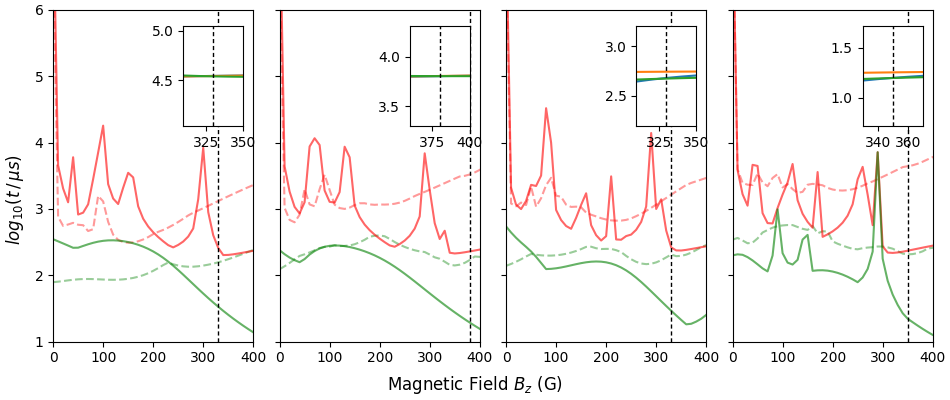

In [20]:
show_optimisation_results(possibilities_d,*r,save_name=f"{MOLECULE_STRING}-qubit",latex_table=True, b_max=400)

# Robust Storage Bit in N=0 Optimisation

In [14]:
print("Robust Storage Qubit N=0 Op}timisation")

possibilities = []
N1=1
N2=0

F1_D = 2*N1+I1_D+I2_D
F2_D = 2*N2+I1_D+I2_D
for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
    for p1 in [-1,0,1]:
        for p2 in [-1,0,1]:
            if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                continue
            MF2a_D = MF1_D+2*p1
            MF2b_D = MF1_D+2*p2
            if MF2a_D < MF2b_D:
                continue
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2a_D)):
                    for k in range(label_degeneracy(N2,MF2b_D)):
                        if MF2a_D == MF2b_D and j <= k:
                            continue
                        possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

Robust Storage Qubit N=0 Op}timisation


In [15]:
print(possibilities_d.shape)

(4432, 3, 3)


In [16]:
# maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],table_len=12,x_plots=4,y_plots=3,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)
with ProgressBar(total=len(possibilities_d)) as progress:
    r = maximise_fid_dev(possibilities_d[:], progress, required_crossing=(0,2),
                         travel_frac=0.2, pol_eff=0.7, dev_exp=(1/3))

  0%|                                                                                                         …

4432 combinations to consider


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


states,B(G),unpolDB(mG),polDB(mG),unpoltg(us),poltg(us),unpoltd(us),poltd(us),rating,path
"(0,4,1),(1,4,5),(0,4,0)",50,39,92,720,300,0,0,1,"(0,4,1)"
"(0,1,3),(1,0,8),(0,0,2)",170,89,340,1800,470,1200,310,0.66,"(0,1,3)<(+3)<(0,4,1)"
"(0,2,3),(1,3,8),(0,2,2)",120,10,27,920,360,320,91,0.52,"(1,3,8)<(0,4,1)"
"(0,2,3),(1,1,3),(0,2,2)",120,9.9,33,1100,340,420,120,0.48,"(0,2,3)<(1,3,2)<(0,4,1)"
"(0,1,3),(1,1,2),(0,1,1)",40,6.3,12,650,350,1600,290,0.45,"(0,1,3)<(+3)<(0,4,1)"
"(0,3,2),(1,3,1),(0,3,0)",40,3.4,10,890,290,820,160,0.39,"(1,3,1)<(0,4,1)"
"(0,1,3),(1,0,3),(0,1,2)",90,20,31,1000,650,3300,290,0.37,"(0,1,3)<(+3)<(0,5,0)"
"(0,0,3),(1,-1,8),(0,-1,2)",150,11,43,1800,430,1700,360,0.33,"(0,0,3)<(+3)<(0,4,1)"


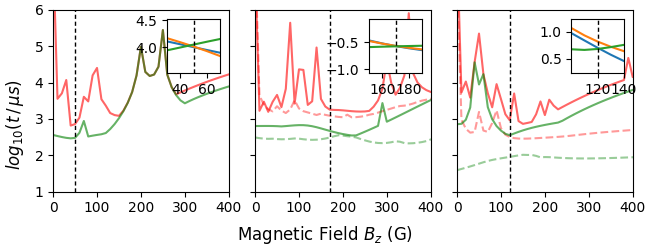

In [17]:
show_optimisation_results(possibilities_d,*r, b_max=400, save_name=f"{MOLECULE_STRING}-qubit-zero",latex_table=True,x_plots=3,figsize=(6.5,2.5))

# Varying time for a set of states

# 2-state

In [21]:

print(TRANSITION_LABELS_D[6226])
print(TRANSITION_GATE_TIMES_POL[6226,field_to_bi(199)]*1e6*10**(3/2))
# EDGE_JUMP_LIST[]

[ 1 12  0  2 14  0]
5.553603672697958e-08


In [22]:
print("2-state optimisation")

states=[]
for N1 in range(0,N_MAX_STRUCTURES): #[1]:#
    N2=N1+1
    F1_D = 2*N1+I1_D+I2_D
    for MF1_D in range(-F1_D,F1_D+1,2):
        for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    states.append([(N1,MF1_D,i),(N2,MF2_D,j)])           
states=np.array(states)

2-state optimisation


In [23]:
# maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],table_len=12,x_plots=4,y_plots=3,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)
with ProgressBar(total=len(states)) as progress:
    r = maximise_fid_dev(states[:,:], progress)

  0%|                                                                                                         …

5300 combinations to consider


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


states,B(G),unpolDB(mG),polDB(mG),unpoltg(us),poltg(us),unpoltd(us),poltd(us),rating,path
"(1,6,0),(2,7,0)",200,3800,3.8e+12,55,0,130,0,1,"(1,6,0)<(0,5,0)"
"(0,4,1),(1,4,3)",860,1500,230000,91,0.57,0,0,0.78,"(0,4,1)"
"(1,3,2),(2,2,2)",380,400,8300,63,3,250,2.7,0.7,"(1,3,2)<(0,4,1)"
"(0,5,0),(1,6,0)",160,1900,3.8e+12,110,0,0,0,0.63,"(0,5,0)"
"(0,5,0),(1,5,0)",990,1200,280000,110,0.47,0,0,0.63,"(0,5,0)"
"(1,5,2),(2,6,2)",420,540,38000,86,1.2,290,2.4,0.57,"(1,5,2)<(0,4,1)"
"(1,4,0),(2,3,0)",470,690,51000,95,1.3,320,6.7,0.51,"(1,4,0)<(0,5,0)"
"(1,3,8),(2,4,9)",250,190,8000,75,1.7,340,82,0.49,"(1,3,8)<(0,4,1)"


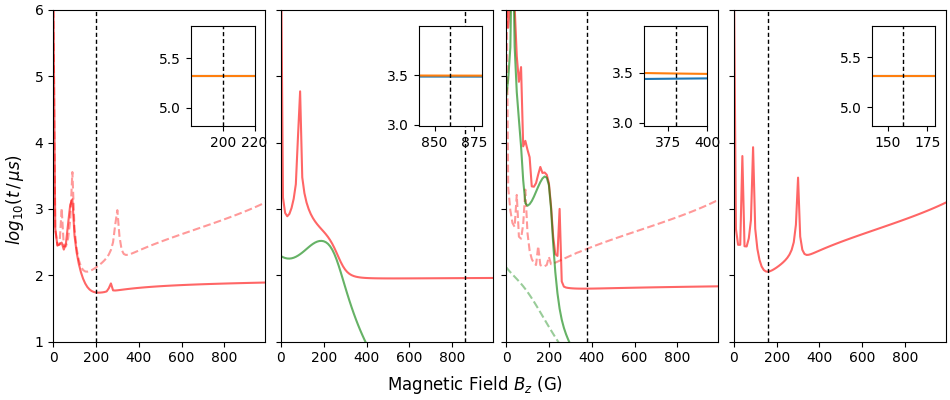

In [24]:
show_optimisation_results(states,*r,save_name=f"{MOLECULE_STRING}-2-state",latex_table=True)


# 3-state

In [ ]:
print("3-state optimisation")

states=[]
N1=0
N2=1
N3=2
F1_D = 2*N1+I1_D+I2_D
for MF1_D in range(-F1_D,F1_D+1,2):
    for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
        for MF3_D in [MF2_D-2,MF2_D,MF2_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    for k in range(label_degeneracy(N3,MF3_D)):
                        states.append([(N1,MF1_D,i),(N2,MF2_D,j),(N3,MF3_D,k)])           
states=np.array(states)

In [ ]:
states.shape

In [ ]:
# maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],table_len=12,x_plots=4,y_plots=3,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)
with ProgressBar(total=len(states)) as progress:
    r = maximise_fid_dev(states, progress)

In [ ]:
show_optimisation_results(states,*r,save_name=f"{MOLECULE_STRING}-3-state",latex_table=True)

# 4-state loop Optimisation

In [25]:
print("4-state loop optimisation")

# Find all possible combinations
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = []            
F1_D = I1_D+I2_D
for base_mf_d in range(-F1_D,F1_D+1,2):
    for p1,p2,p3,_ in polarisations:
        state_mfs.append((base_mf_d,base_mf_d+2*p1,base_mf_d+2*p1+2*p2,base_mf_d+2*p1+2*p2+2*p3))

states = []
for state_mf in state_mfs:
    for i in range(label_degeneracy(0,state_mf[0])):
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)

4-state loop optimisation


In [26]:
# maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],table_len=12,x_plots=4,y_plots=3,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)
with ProgressBar(total=len(states)) as progress:
    r = maximise_fid_dev(states[:], progress, loop=True)

  0%|                                                                                                         …

504014 combinations to consider


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


states,B(G),unpolDB(mG),polDB(mG),unpoltg(us),poltg(us),unpoltd(us),poltd(us),rating,path
"(0,4,1),(1,4,3),(2,4,4),(1,3,2)",710,33,230,1100,150,0,0,1,"(0,4,1)"
"(0,2,0),(1,3,3),(2,2,4),(1,2,1)",400,120,950,1400,180,5300,250,1,"(0,2,0)<(+5)<(0,4,1)"
"(0,1,0),(1,2,4),(2,1,4),(1,1,1)",380,130,990,1400,180,6400,280,1,"(0,1,0)<(+7)<(0,4,1)"
"(0,0,0),(1,1,4),(2,0,2),(1,0,1)",330,96,720,1300,180,6700,170,0.93,"(0,0,0)<(+9)<(0,5,0)"
"(0,4,1),(1,5,2),(2,4,4),(1,4,3)",500,24,110,870,190,0,0,0.93,"(0,4,1)"
"(0,3,0),(1,4,2),(2,3,2),(1,3,1)",380,81,640,1500,190,3300,170,0.91,"(0,3,0)<(+5)<(0,4,1)"
"(0,5,0),(1,6,0),(2,5,0),(1,5,0)",960,51,410,1500,190,0,0,0.84,"(0,5,0)"
"(0,-1,0),(1,0,4),(2,-1,2),(1,-1,1)",310,62,450,1300,180,6700,300,0.81,"(1,-1,1)<(+12)<(0,5,0)"


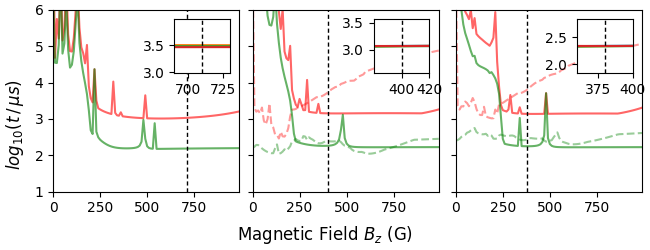

In [27]:
show_optimisation_results(states,*r,save_name=f"{MOLECULE_STRING}-4-state",latex_table=True, x_plots=3, figsize=(6.5,2.5))

# Optimise in terms of t_g

In [ ]:
states = [(0,8,1),(1,8,0),(0,8,0)]
desired_indices = [label_d_to_node_index(*label) for label in states]


# Find best B for minimum dipole deviation
all_moments = MAGNETIC_MOMENTS[:,desired_indices]
this_deviation = np.abs((np.amax(all_moments,axis=1) - np.amin(all_moments,axis=1)))

DESIRED_FIDELITY = 0.999

# required_deviation = all_moments[:,0]-all_moments[:,2]
# sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
# mask = np.ones(max_bi, dtype=bool)
# mask[sign_changes] = False
# mask[sign_changes+1] = False
# this_rating[mask] = 0

# Find best times
t_required_global_max_unpol = np.zeros(B_STEPS, dtype=np.double)
t_required_global_max_pol = np.zeros(B_STEPS, dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label

    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]
    
    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    deltas_up   = np.abs(ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])/H_BAR
    deltas_down = np.abs(ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])/H_BAR
    
    mask_up = up_node_indices == to_node_index
    mask_down = down_node_indices == from_node_index
    
    deltas_up[mask_up,:] = 1e9*np.ones(B_STEPS)
    deltas_down[mask_down,:] = 1e9*np.ones(B_STEPS)

    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)
    
    ###
    t_required_up_unpol = (2*gs_up*np.pi)/(deltas_up)    
    t_required_down_unpol = (2*gs_down*np.pi)/(deltas_down)
    t_required_max_up_unpol = np.max(t_required_up_unpol, axis=0, initial=0)
    t_required_max_down_unpol = np.max(t_required_down_unpol, axis=0, initial=0)
    t_required_max_unpol = np.maximum(t_required_max_up_unpol,t_required_max_down_unpol)
    t_required_global_max_unpol = np.maximum(t_required_max_unpol,t_required_global_max_unpol)
    
    start_index_from = from_neighbours[0]
    start_index_to = to_neighbours[0]
    t_required_up_pol = t_required_up_unpol[from_neighbours[section_index]-start_index_from:from_neighbours[section_index+1]-start_index_from,:]
    t_required_down_pol = t_required_down_unpol[to_neighbours[section_index+3]-start_index_to:to_neighbours[section_index+4]-start_index_to,:]
    t_required_max_up_pol = np.max(t_required_up_pol, axis=0, initial=0)    
    t_required_max_down_pol = np.max(t_required_down_pol, axis=0, initial=0)
    t_required_max_pol = np.maximum(t_required_max_up_pol,t_required_max_down_pol)
    t_required_global_max_pol = np.maximum(t_required_max_pol,t_required_global_max_pol)
    
delta_b_required_unpol = (scipy.constants.h) / (this_deviation * t_required_global_max_unpol)
delta_b_required_pol = (scipy.constants.h) / (this_deviation * t_required_global_max_pol)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,constrained_layout=True)
ax1.set_xlim(0,B_MAX/GAUSS)

# Simulate microwave transfers to find fidelity *within structure*
total_fid_opt = np.ones(B_STEPS,dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label
    
    fs_up_opt, fs_down_opt = unpolarised_edge_to_fs(from_label, to_label, t_gate=t_required_global_max_unpol)
    total_fid_opt *= np.prod(fs_up_opt,axis=0)
    total_fid_opt *= np.prod(fs_down_opt,axis=0)
    total_fid_opt *= 4

MAX_TIME_US = 2000
X=B/GAUSS

Y=t_required_global_max_pol*1e6
ax1.plot(X,Y,alpha=0.9,c='green') # us
# ax.fill_between(X, Y, MAX_TIME_US, color= "green", alpha= 0.3)

Y=t_required_global_max_unpol*1e6
ax1.plot(X,Y,alpha=0.9,c='red') # us
ax1.set_yscale('log', base=10)
# ax.fill_between(X, Y, MAX_TIME_US, color= "red", alpha= 0.3)

Y = delta_b_required_pol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='green') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_unpol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='red') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_pol/(t_required_global_max_pol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='green')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='green',linewidth=1,dashes=(3,2))
    
Y = delta_b_required_unpol/(t_required_global_max_unpol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='red')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='red',linewidth=1,dashes=(3,2))

ax1.set_ylabel("$t'_{g}\, (\mu s)$")
ax2.set_ylabel("$\Delta B'\, (m G)$")
ax3.set_xlabel("B $(G)$")

t_g_unpol = t_required_global_max_unpol[Y_max_arg] #* (1-d_f)**(-1/2)
t_g_pol = t_required_global_max_pol[Y_max_arg] #* (1-d_f)**(-1/2)
d_b_g = delta_b_required_unpol[Y_max_arg] #* (1-d_f)**(3/2)

for d in range(0,5):
    print(d, "=", 1-10**(-d))
    print(f"{t_g_unpol * 10**(d/2) * 1e6:.2f}us unpolarised")
    print(f"{t_g_pol * 10**(d/2) * 1e6:.2f}us polarised")
    print(f"{d_b_g * 10**(-3*d/2) *1e4*1e3:.2f}mG")
    print("----")

# ax.set_title("0.999 Fidelity")

In [ ]:
fig,ax = plt.subplots()
to_plot = label_d_to_edge_indices(0,10,0)
print(to_plot)
for i in range(to_plot[0],to_plot[3]):
    ax.plot(B/GAUSS,np.abs(COUPLINGS_SPARSE[i,:]))
    
ax.set_xlim(0,1000)
ax.set_ylim(0,1)

# Form fidelity

# All pairs best fidelity

In [ ]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    k2 = k**2
    k4 = k2**2
    g2 = g**2
    g4 = g2**2
    g2p1 = 1+g2
    g2p12 = g2p1*g2p1
    g2p13 = g2p12*g2p1
    return (g2p12 + k2*(16*g2p1-24) + 16*k4)/(g2p13 + (-8 + 20*g2 + g4)*k2 + 16*k4)

In [ ]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    if np.any(k):
        return 1-np.abs(g)**2/np.abs(k)**2
    else:
        return 0.5*np.ones(k.shape)

In [ ]:
def polarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = TRANSITION_INDICES[from_neighbours[section_index]:from_neighbours[section_index+1],1]
    down_node_indices = TRANSITION_INDICES[to_neighbours[section_index+3]:to_neighbours[section_index+4],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = COUPLINGS_SPARSE[from_neighbours[section_index]:from_neighbours[section_index+1],:]/specific_coupling
    gs_down = COUPLINGS_SPARSE[to_neighbours[section_index+3]:to_neighbours[section_index+4],:]/specific_coupling

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [ ]:
def unpolarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if  P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = TRANSITION_INDICES[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = TRANSITION_INDICES[to_neighbours[3]:to_neighbours[6],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [ ]:
start_label_d = (0,10,0)
end_label_d = (1,10,1)
fs_up, fs_down = unpolarised_edge_to_fs(start_label_d, end_label_d, t_gate=500*1e-6*np.ones(B_STEPS))

In [ ]:
fig,ax=plt.subplots()
for f_up in fs_up:
    if np.allclose(f_up,0.5*np.ones(B_STEPS)):
        continue
    ax.plot(B/GAUSS,-np.log10(1-f_up+1e-6).T,c='red',alpha=0.5)
    
for f_down in fs_down:
    if np.allclose(f_down,0.5*np.ones(B_STEPS)):
        continue
    ax.plot(B/GAUSS,-np.log10(1-f_down+1e-6).T,c='blue',alpha=0.5)

fs_tot = np.prod(np.clip(fs_up,0.0001,1),axis=0)*np.prod(np.clip(fs_down,0.0001,1),axis=0)*4
ax.plot(B/GAUSS, -np.log10(1-fs_tot+1e-6),c='black',linestyle='dashed')

ax.set_ylim(0,6)
ax.set_xlim(0,400)
# plt.show()
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Fidelity 9\'s per off resonant state')
ax.set_title(rf"${label_d_to_latex_string(start_label_d)} \rightarrow {label_d_to_latex_string(end_label_d)}$")

In [ ]:
fig,ax=plt.subplots()
for f_up in fs_up:
    if np.allclose(f_up,0.5*np.ones(B_STEPS)):
        continue
    ax.plot(B/GAUSS,-np.log10(1-f_up+1e-6).T,c='red',alpha=0.5)
    
for f_down in fs_down:
    if np.allclose(f_down,0.5*np.ones(B_STEPS)):
        continue
    ax.plot(B/GAUSS,-np.log10(1-f_down+1e-6).T,c='blue',alpha=0.5)

fs_tot = np.prod(np.clip(fs_up,0.0001,1),axis=0)*np.prod(np.clip(fs_down,0.0001,1),axis=0)*4
ax.plot(B/GAUSS, -np.log10(1-fs_tot+1e-6),c='black',linestyle='dashed')

ax.set_ylim(0,6)
ax.set_xlim(0,400)
# plt.show()
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Fidelity 9\'s per off resonant state')
ax.set_title(rf"${label_d_to_latex_string(start_label_d)} \rightarrow {label_d_to_latex_string(end_label_d)}$")

In [ ]:
# Plot Times

In [ ]:
sil=label_d_to_edge_indices(0,8,1)
print(sil)
si = sil[1]+1

fig,(ax1) = plt.subplots(1,1,sharex=True,constrained_layout=True)
ax1.set_xlim(0,B_MAX/GAUSS)
ax1.set_yscale('log', base=10)

X=B/GAUSS

Y=TRANSITION_GATE_TIMES_POL[si]*1e6
ax1.plot(X,Y,alpha=0.9,c='green') # us

Y=TRANSITION_GATE_TIMES_UNPOL[si]*1e6
ax1.plot(X,Y,alpha=0.9,c='red') # us

In [ ]:
# Test it makes sense
test_si = label_d_to_node_index(0,3,2)
test_bi = 100

print(CUMULATIVE_TIME_FROM_INITIALS_UNPOL[test_si,test_bi])

back_si = test_si
while back_si >= 0:
    print(generated_labels[back_si])
    back_si = PREDECESSOR_UNPOL[back_si,test_bi]